In [19]:
from typing import TypedDict, List, Dict, Any, Optional
from dotenv import load_dotenv
import os

from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI

load_dotenv()


True

## dummy graph to classify spam/ham


In [ ]:
model = AzureChatOpenAI(azure_deployment=os.getenv("AZURE_OPENAI_GPT4O_DEPLOYMENT_NAME"), temperature=0)


class EmailState(TypedDict):
    email: Dict[str, Any]
    email_category: Optional[str]
    spam_reason: Optional[str]
    is_spam: Optional[bool]
    email_draft: Optional[str]
    messages: List[Dict[str, Any]]


def read_email(state: EmailState):
    print("Agent has received an email from {} with subject: {}. Agent will start processing it!".format(
        state["email"]["sender"],
        state["email"]["subject"]
    ))
    return {}


def classify_email_using_llm(state: EmailState):
    prompt = """
    Please analyze the below email and return information about it.
    The response should be in the three following sections:

    The first section should argue whether the email is spam or not.
    The response should be short and to the point and focus on email content only.

    The second section should take the conclusion from the first section and classify the email spam/legitimate.
    Return one word only. If spam write "spam" otherwise "legitimate".

    The third section should classify the email into one or the following categories:
    "inquiry", "complaint", "thank_you", "request", "information", or "other"
    The section should be a single word only.

    Each section should be separated by 5 dashes, like this: =====

    -------------------------------

    Email:
    From: {}
    Subject: {}
    Body: {}
    """.format(
        state["email"]["sender"],
        state["email"]["subject"],
        state["email"]["body"]
    )


    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    response_text = response.content.lower()

    sections = response_text.split("=====")

    spam_reason = sections[0].replace('\n', '').strip()
    is_spam = "SPAM" in sections[1].upper()
    email_category = sections[2].replace('\n', '').strip()

    messages = state.get("messages", [])
    if not is_spam:
        messages.append({"role": "user", "content": prompt})
        messages.append({"role": "assistant", "content": response.content})

    print(f"Agent has classified the email. {is_spam=}, {email_category=}")

    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": messages
    }



def handle_spam(state: EmailState):
    print("Agent has moved to the spam folder. Reason: {}".format(
        state['spam_reason']
    ))
    return {}


def draft_response(state: EmailState):
    prompt = """
    Draft a polite preliminary response to this email.

    From: {}
    Subject: {}
    Body: {}

    This email has been categorized as: {}

    Draft a brief, professional response that a user may review and personalize before sending.
    """.format(
        state["email"]["sender"],
        state["email"]["subject"],
        state["email"]["body"],
        state["email_category"] or "general"
    )

    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    messages = state.get("messages", [])
    messages.append({"role": "user", "content": prompt})
    messages.append({"role": "assistant", "content": response.content})

    return {
        "email_draft": response.content,
        "messages": messages
    }


def notify_user(state: EmailState):
    email = state["email"]
    print("\n" + "="*50)
    print(f"Dear Sir or Madam")
    print(f"You have received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")

    return {}


def route_email(state: EmailState) -> str:
    return "spam" if state["is_spam"] else "legitimate"


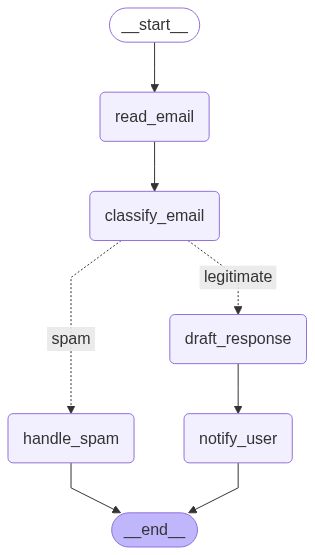

In [27]:
# build the graph to sequence the logical steps/workflow of our agent

builder = StateGraph(EmailState)

builder.add_node("read_email", read_email)
builder.add_node("classify_email", classify_email_using_llm)
builder.add_node("handle_spam", handle_spam)
builder.add_node("draft_response", draft_response)
builder.add_node("notify_user", notify_user)

builder.add_edge(START, "read_email")
builder.add_edge("read_email", "classify_email")
builder.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)
builder.add_edge("handle_spam", END)
builder.add_edge("draft_response", "notify_user")
builder.add_edge("notify_user", END)
app = builder.compile()

display(Image(app.get_graph().draw_mermaid_png()))


# apply agent workflow


In [28]:
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. James, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}
legitimate_result = app.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Agent has received an email from john.smith@example.com with subject: Question about your services. Agent will start processing it!
Agent has classified the email. is_spam=False, email_category='inquiry'

Dear Sir or Madam
You have received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Question about our services

Dear Mr. Smith,

Thank you for reaching out and for your interest in our consulting services. I would be delighted to discuss how we can assist you. Please let me know your availability for a call next week, and I will do my best to accommodate.

Looking forward to our conversation.

Best regards,

[Your Name]  
[Your Position]  
[Your Company]  
[Your Contact Information]



In [29]:
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}
spam_result = app.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Agent has received an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!. Agent will start processing it!
Agent has classified the email. is_spam=True, email_category='other'
Agent has moved to the spam folder. Reason: the first section should argue whether the email is spam or not.this email exhibits several characteristics commonly associated with spam. the sender's email address, "winner@lottery-intl.com," is not from a recognized or reputable organization. the subject line, "you have won $5,000,000!!!," uses excessive capitalization and exclamation marks, which are typical of spam emails designed to grab attention. the body of the email promises a large sum of money in exchange for personal information and a processing fee, which is a classic sign of a scam. legitimate lotteries do not require winners to pay fees to claim their prizes, and they do not ask for sensitive information like bank details via email.


True